In [109]:
# automatically reload when making changes in module files (only needs to be run once)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# imports
import numpy as np
import copy
import plotly.offline as py
from fracture_fea_laf import mesh, plot

from abaqus_parse.materials import generate_material_models
from abaqus_parse.parts import generate_compact_tension_specimen_parts, generate_bend_bar_specimen_parts
from abaqus_parse.steps import generate_compact_tension_specimen_steps, generate_threepoint_bend_test_steps
from abaqus_parse import writers

In [112]:
mesh

<module 'fracture_fea_laf.mesh' from 'c:\\users\\mbgm9my2\\dropbox (research group)\\calculations-code\\code\\matsci-tools\\fracture-fea-laf\\fracture_fea_laf\\mesh.py'>

# Mesh definition

The schematic below shows the parameters required to define the mesh:
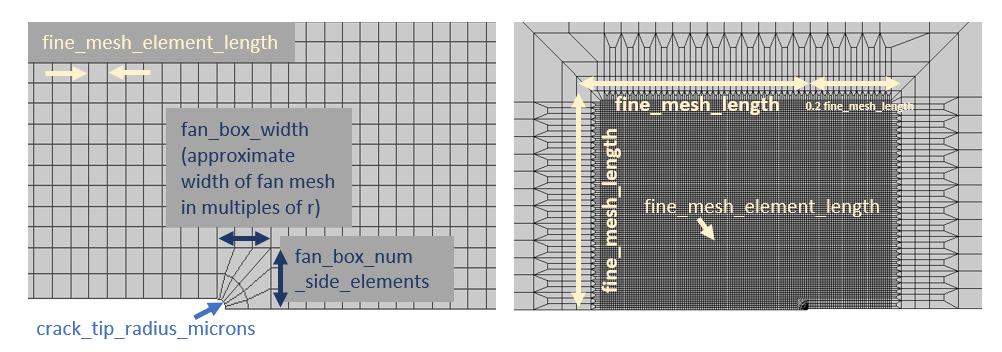

In [97]:
# USER INPUT
################################################
# FAN MESH 
# crack tip radius in micrometers, r
crack_tip_radius_microns = 10

# approximate width of fan mesh in multiples of r
fan_box_width = 5

# number of elements to split half of the crack tip curvature
fan_box_num_side_elements = 3

# NOTE: some sensible adjustment is needed between the three parameters, 
# suitable triplets are listed below
crack_tip_radius_microns, fan_box_width, fan_box_num_side_elements = 10, 5, 3
crack_tip_radius_microns, fan_box_width, fan_box_num_side_elements = 20, 5, 4
crack_tip_radius_microns, fan_box_width, fan_box_num_side_elements = 30, 4, 5
crack_tip_radius_microns, fan_box_width, fan_box_num_side_elements = 70, 2, 3
################################################
# FINE MESH
# fine mesh element side
fine_mesh_element_length = 0.02 #0.02

# side of square element in the fine mesh region
# redefined in Step 3 based on temperature)
fine_mesh_length = 0.2
################################################
# GLOBAL
dimension = '3D' # 3D | 2D
element_type = 'C3D8R' # C3D8R | CPE4

# if 3D, specify these two parameters, None if 2D
number_layers = 10 # None | 10 | 20
element_thickness = 'uniform' # None | uniform | variable 

# Geometry definition

In [103]:
# USER INPUT
size_type = 'ct-1t'  # 'ct-1t' | 'charpy-senb-0.5' | 'charpy-senb-0.2'
fraction = 'quarter'  # quarter | half | full


# Physical parameters & temperature dependent mesh parameters

In [104]:
working_temp, applied_disp, num_contours, fine_mesh_length = -154, 0.18, 40, 0.6
# working_temp, applied_disp, num_contours, fine_mesh_length = -91, 0.58, 40, 2.2
# working_temp, applied_disp, num_contours, fine_mesh_length = -60, 0.6, 60, 3.4
# working_temp, applied_disp, num_contours, fine_mesh_length = -40, 0.9, 70, 3.8
specimen_material = 'euromat_A'

# values only for guidance - change according to ease of convergence
time_increment_definition = {
    'initial_time_increment': 0.01, 
    'total_step_time': 1.0,
    'min_time_increment_allowed': 1e-10, 
    'max_time_increment_allowed': 0.01,
}

# Create materials

In [105]:
mat_list = [
# ONLY NEEDED FOR CT
        {
        'name': 'rigid',
        'elastic': {
            'youngs_modulus': 2000000,
            'poisson_ratio': 0.3
        },
    },
    {
        'name': specimen_material,
        'func_name': specimen_material,
        'temp': working_temp,
    }
]

materials = generate_material_models(mat_list)

# Create parts

In [106]:
mesh_definition = {
    'crack_tip_radius_microns': crack_tip_radius_microns,
    'fine_mesh_length': fine_mesh_length,
    'fine_mesh_element_length': fine_mesh_element_length,
    'fan_box_num_side_elements': fan_box_num_side_elements,
    'fan_box_width': fan_box_width,
    'number_layers': number_layers,
    'element_thickness': element_thickness,
}
# generate_compact_tension_specimen_parts | generate_bend_bar_specimen_parts
parts = generate_compact_tension_specimen_parts(dimension, mesh_definition,
                     element_type, size_type, fraction, specimen_material)

# Create steps

In [107]:
# generate_compact_tension_specimen_steps | generate_threepoint_bend_test_steps
steps_definition = generate_compact_tension_specimen_steps(
    applied_displacement=applied_disp,
    number_contours=num_contours,
    time_increment_definition=time_increment_definition,
    number_layers=mesh_definition['number_layers']
)

# Write input

In [108]:
out_path = './save-input-data/model.inp'
writers.write_inp(out_path, materials, parts, steps_definition)